# Explorative data analysis of the Airbnb Seattle data set
This notebook covers a short explorative data analysis (EDA) of an Airbnb Seattle dataset.

The dataset consists of three files (calendar.csv, listings.csv, reviews.csv) nad can be found here:
https://www.kaggle.com/datasets/airbnb/seattle/data

Let's think of someone who wants to offer a room but does not know what a fair price to charge would be.

A good starting point for this person is to know what others with similar rooms would charge and what influences the price in general.

Three questions about the dataset are answered in this analysis:

1. What is the price profile of different locations?

2. How does the season relate to the price?

3. How do room type, property type and amenities relate to the price?

It also predicts the price with an XGBoost regression model

In [128]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

In [129]:
# Load the datafiles
df_calendar = pd.read_csv('./Data/calendar.csv')

df_listings= pd.read_csv('./Data/listings.csv')

# First visual inspection
display(df_calendar.head())
display(df_listings.head())

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


## Data cleaning and value conversion
- Cleaning of nan entries
- Conversion of price related entries from string to numeric

In [130]:
# Inspect the missing values and datatypes
display(df_listings.info())
display(df_calendar.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


None

In [131]:
# Data cleaning (listings)
#######
# Drop all rows with missing price or property type (as it is just 1 row)
df_listings.dropna(axis=0, subset=['price', 'property_type'], inplace=True)
# Convert prices to numeric
df_listings['price'] = df_listings['price'].str.replace('$', '').str.replace(',', '').astype("float64")
df_listings['weekly_price'] = df_listings['weekly_price'].str.replace('$', '').str.replace(',', '').astype("float64")
df_listings['monthly_price'] = df_listings['monthly_price'].str.replace('$', '').str.replace(',', '').astype("float64")
df_listings['security_deposit'] = df_listings['security_deposit'].str.replace('$', '').str.replace(',', '').astype("float64")
df_listings['cleaning_fee'] = df_listings['cleaning_fee'].str.replace('$', '').str.replace(',', '').astype("float64")
df_listings['extra_people'] = df_listings['extra_people'].str.replace('$', '').str.replace(',', '').astype("float64")
# Replace nan in bathrooms, bedrooms, beds, security_deposit with 0
df_listings.fillna({'bathrooms': 0, 'bedrooms': 0, 'beds': 0, 'cleaning_fee': 0, 'extra_people': 0, 'security_deposit': 0}, inplace=True)
## Drop all nan columns (more than 50%)
#df_listings.dropna(axis=1, thresh=int(0.8*df_listings.shape[0]), inplace=True)
# Drop all columns with only one value across all rows
df_listings = df_listings.loc[:, df_listings.nunique() > 1]
# Drop all url columns
df_listings.drop(df_listings.columns[df_listings.columns.str.contains("url")], axis=1, inplace=True)
# Drop all host related columns
df_listings.drop(df_listings.columns[df_listings.columns.str.contains("host_")], axis=1, inplace=True)
#######

# Data cleaning (calendar)
#######
# Drop missing price or date rows
df_calendar.dropna(how='any', subset=['date', 'price'], axis=0, inplace=True)
# Convert price to numeric
df_calendar['price'] = df_calendar['price'].apply(lambda x: float(x.replace('$', '').replace(',', '') ) )
#######

## 1. What is the price profile of different locations?
Use the listings.csv data to answer this question.

Look at the median "price" for each neighbourhood.

Only consider neighbourhoods with more then 20 price entries to ensure that the results are statistically meaningful.

### Visualize the grouped neighbourhoods

In [132]:
# Function for the visualization of the neighbourhood impact on the price
def visualize_neighbourhood(dataset, column_neighbourhood, tick_fontsize=14):
    '''
    This function creates a boxplot of the neighbourhood over price in the listings dataset.
    Neighbourhoods with less than 20 price entries are droped to be statistically relevant.
    ylabel and title are deleted from the plot.
    The tick labelsize can be set.
    
    Input:
    dataset: The dataset to use
    x_column, ycolumn: Column names
    hue_column: Column to use for the hue
    tick_fontsize: Fontsize for the tick labels
    
    Output:
    Creates a seaborn boxplot
    Returns the handle to the boxplot axes
    '''
    # Select and clean the dataset (Drop all rows with a missing neighbourhood_group_cleansed or price)
    df_price_ovr_neighbourhood = dataset[['price', column_neighbourhood]]

    # Get the number of rooms for each neigbourhood group and the median
    count_locPrices = df_price_ovr_neighbourhood.groupby(column_neighbourhood).count();
    median_locPrices = df_price_ovr_neighbourhood.groupby(column_neighbourhood).median();

    # Add the median to the dataframe and drop neighbourhoods with less than 20 price entries
    median_data = np.array([median_locPrices.loc[x].values[0] for x in df_price_ovr_neighbourhood[column_neighbourhood]])
    df_price_ovr_neighbourhood.insert(0, column='Median_price', value=median_data)
    df_price_ovr_neighbourhood = df_price_ovr_neighbourhood.loc[(count_locPrices.loc[ df_price_ovr_neighbourhood[column_neighbourhood], :]['price'] > 20).values, :]
    df_price_ovr_neighbourhood = df_price_ovr_neighbourhood.sort_values(by='Median_price', ascending=False);
    
    # Create the boxplot
    fig=plt.figure(figsize=(20,10), dpi= 100, facecolor='w', edgecolor='k')
    sns.set_style('whitegrid')
    axs = sns.boxplot(data=df_price_ovr_neighbourhood, x='price', y=column_neighbourhood, 
                showfliers=False, palette="coolwarm", hue='Median_price');
    axs.xaxis.set_tick_params(labelsize = tick_fontsize)
    axs.yaxis.set_tick_params(labelsize = tick_fontsize)
    axs.set_xlabel('Price', fontsize = 18)
    axs.set_ylabel('')
    axs.set_title('')
    
    return axs


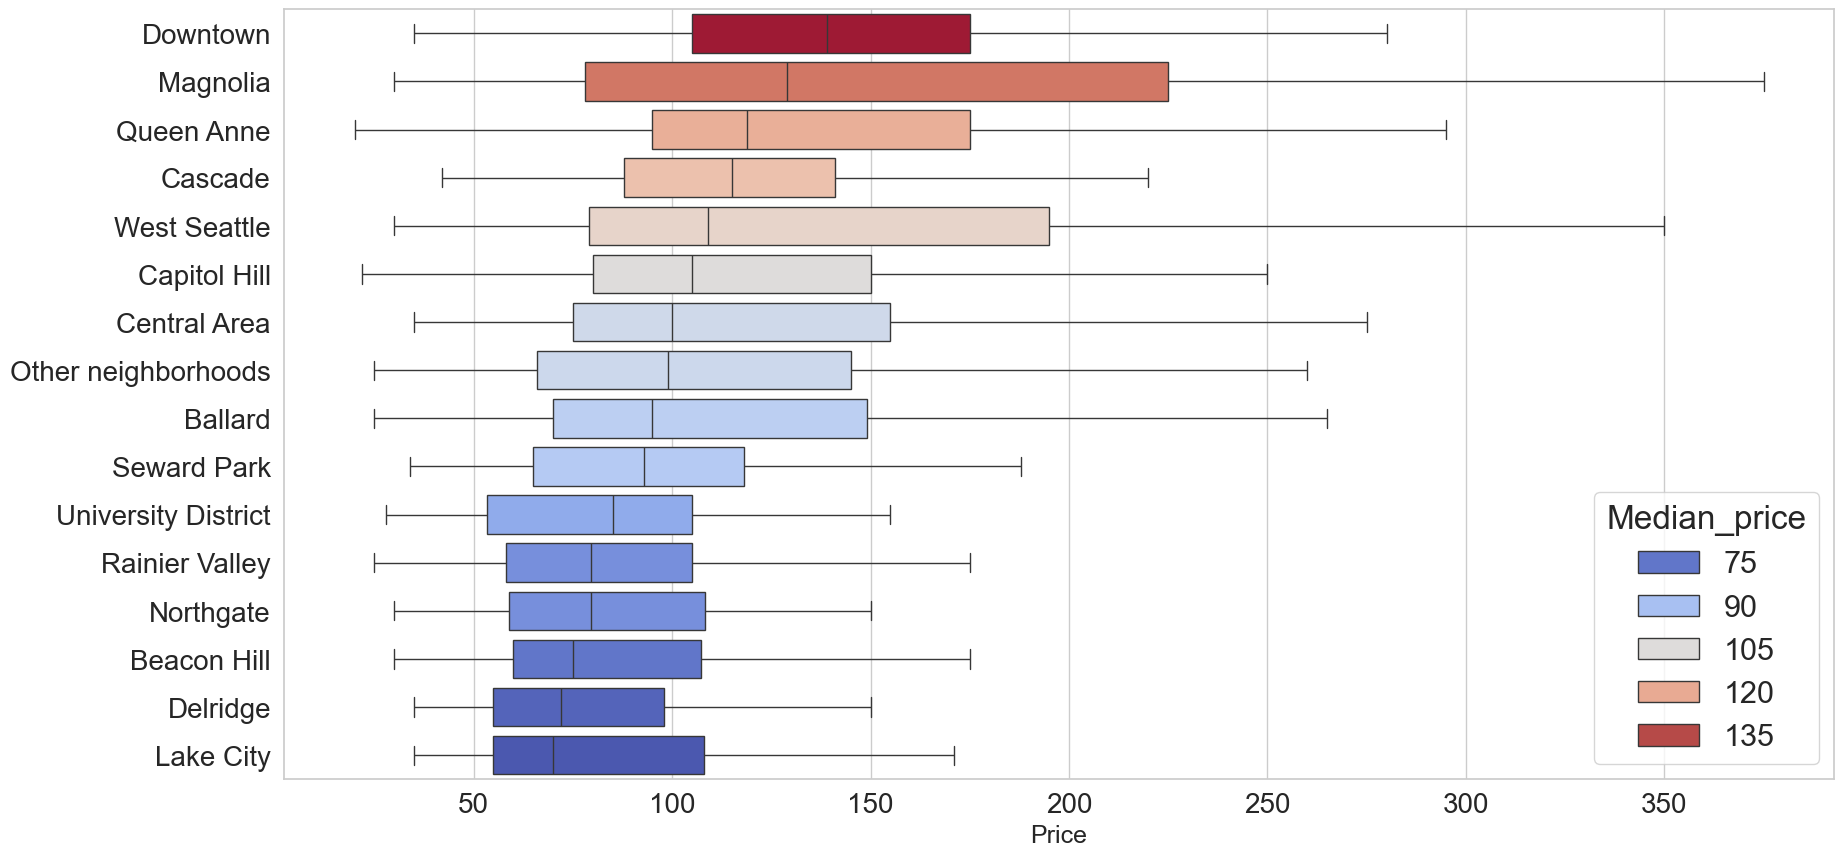

In [133]:
# Visualize the grouped neighbourhoods
visualize_neighbourhood(df_listings, 'neighbourhood_group_cleansed', 20);

### Result
The boxplot can give our fictious room provider a baseline of what the price range for each location is:
- For Downton a good price choice might be 120-180$
- For Lake city it might be mostly between roughly 55-105$
- Magnolia has the second highest median, but a very high value range
- There are no rooms above 180$ in the 6 lower ranked locations

### Let's see how the locations correlate with the price
- There is a low correlation for some of the location groups
- Downtown stands out with a correlation coefficient of 20.9

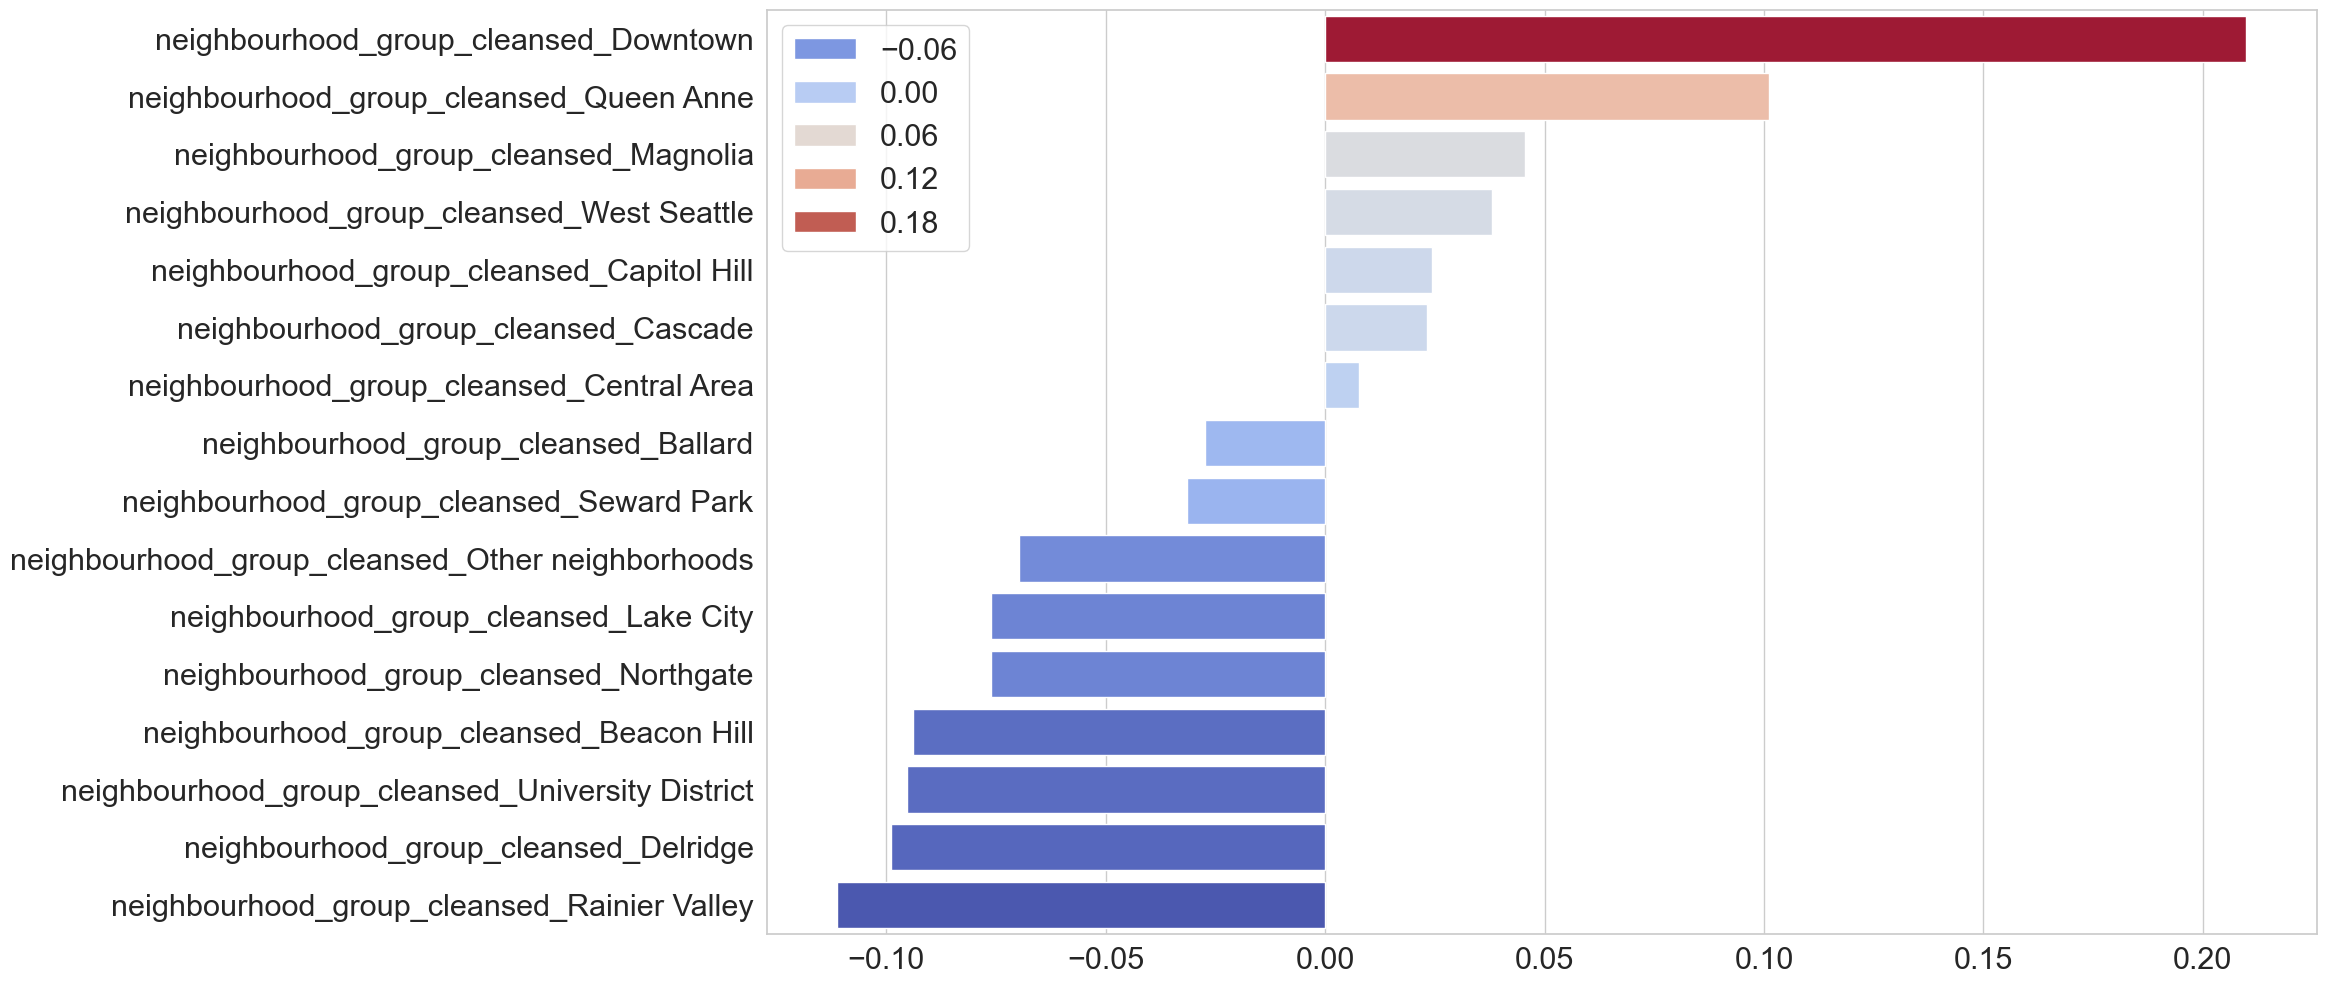

In [134]:
# Correlation location_group_cleansed with price
dummies_location_group = pd.get_dummies(df_review_ovr_neighbourhood_group)
corr_location_group = dummies_location_group.drop(columns='Median_price').corr(method='spearman')['price'].sort_values(ascending=False).drop('price')
fig=plt.figure(figsize=(20,12), facecolor='w', edgecolor='k')
sns.barplot(x=corr_location_group.values, y=corr_location_group.index, palette="coolwarm", hue=corr_location_group.values)
plt.ylabel('');
plt.show()

### For further detail, visualize the more detailed neighbourhoods

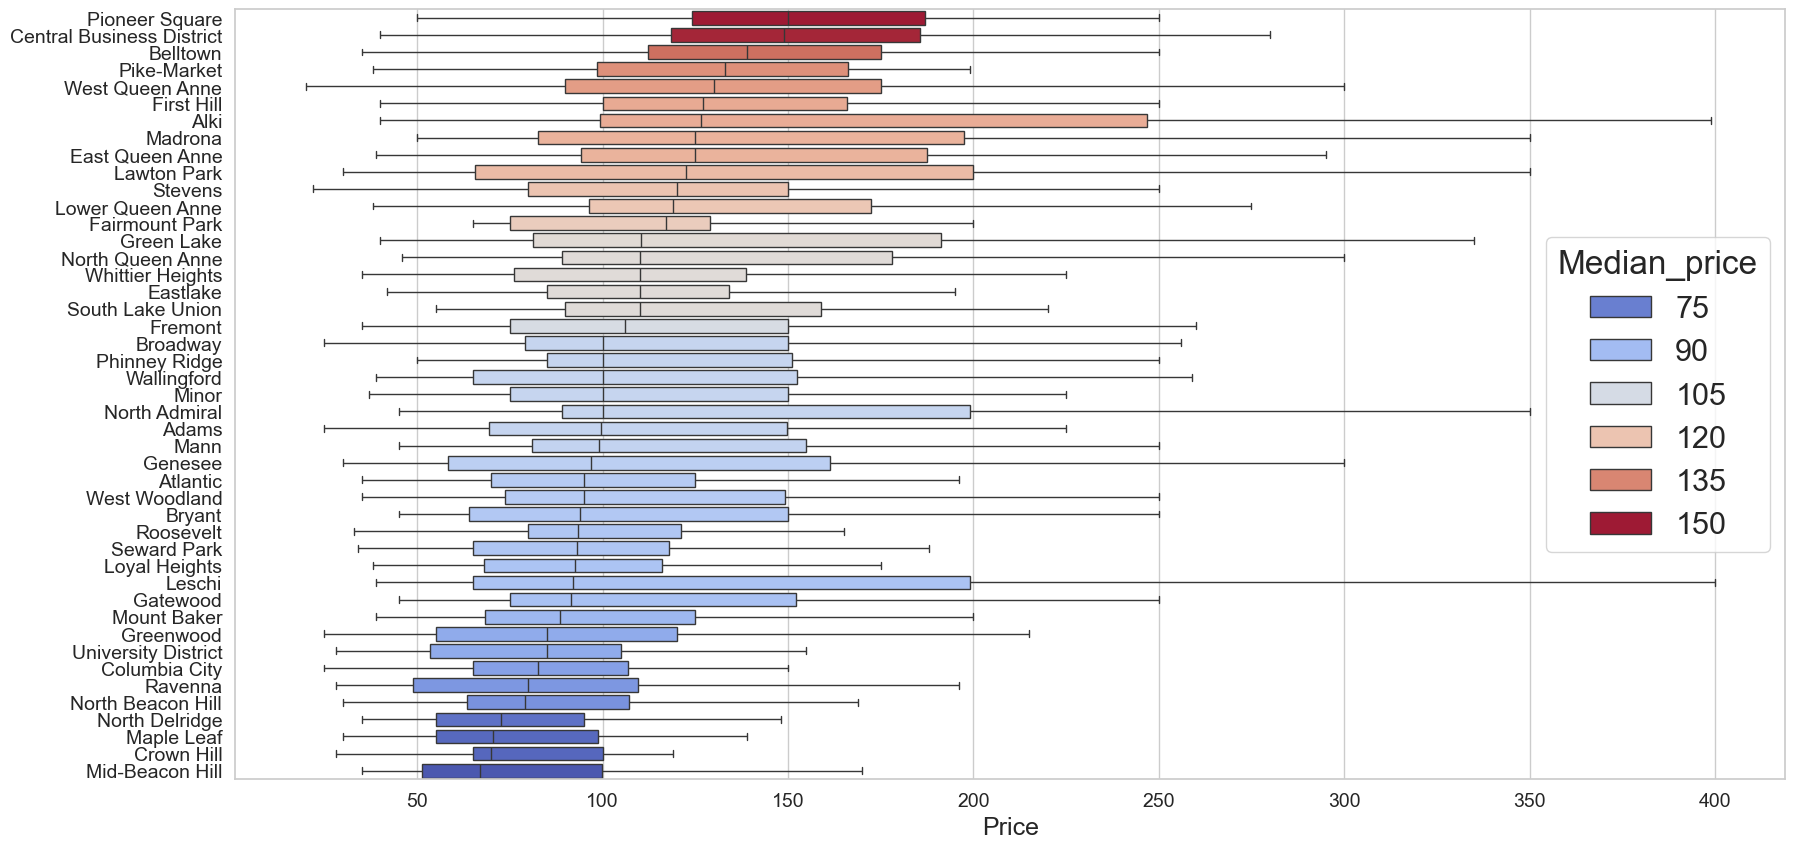

In [135]:
# Visualize the detailed neighbourhoods
visualize_neighbourhood(df_listings, 'neighbourhood_cleansed', 14);

### The correlation of the detailed locations with the price

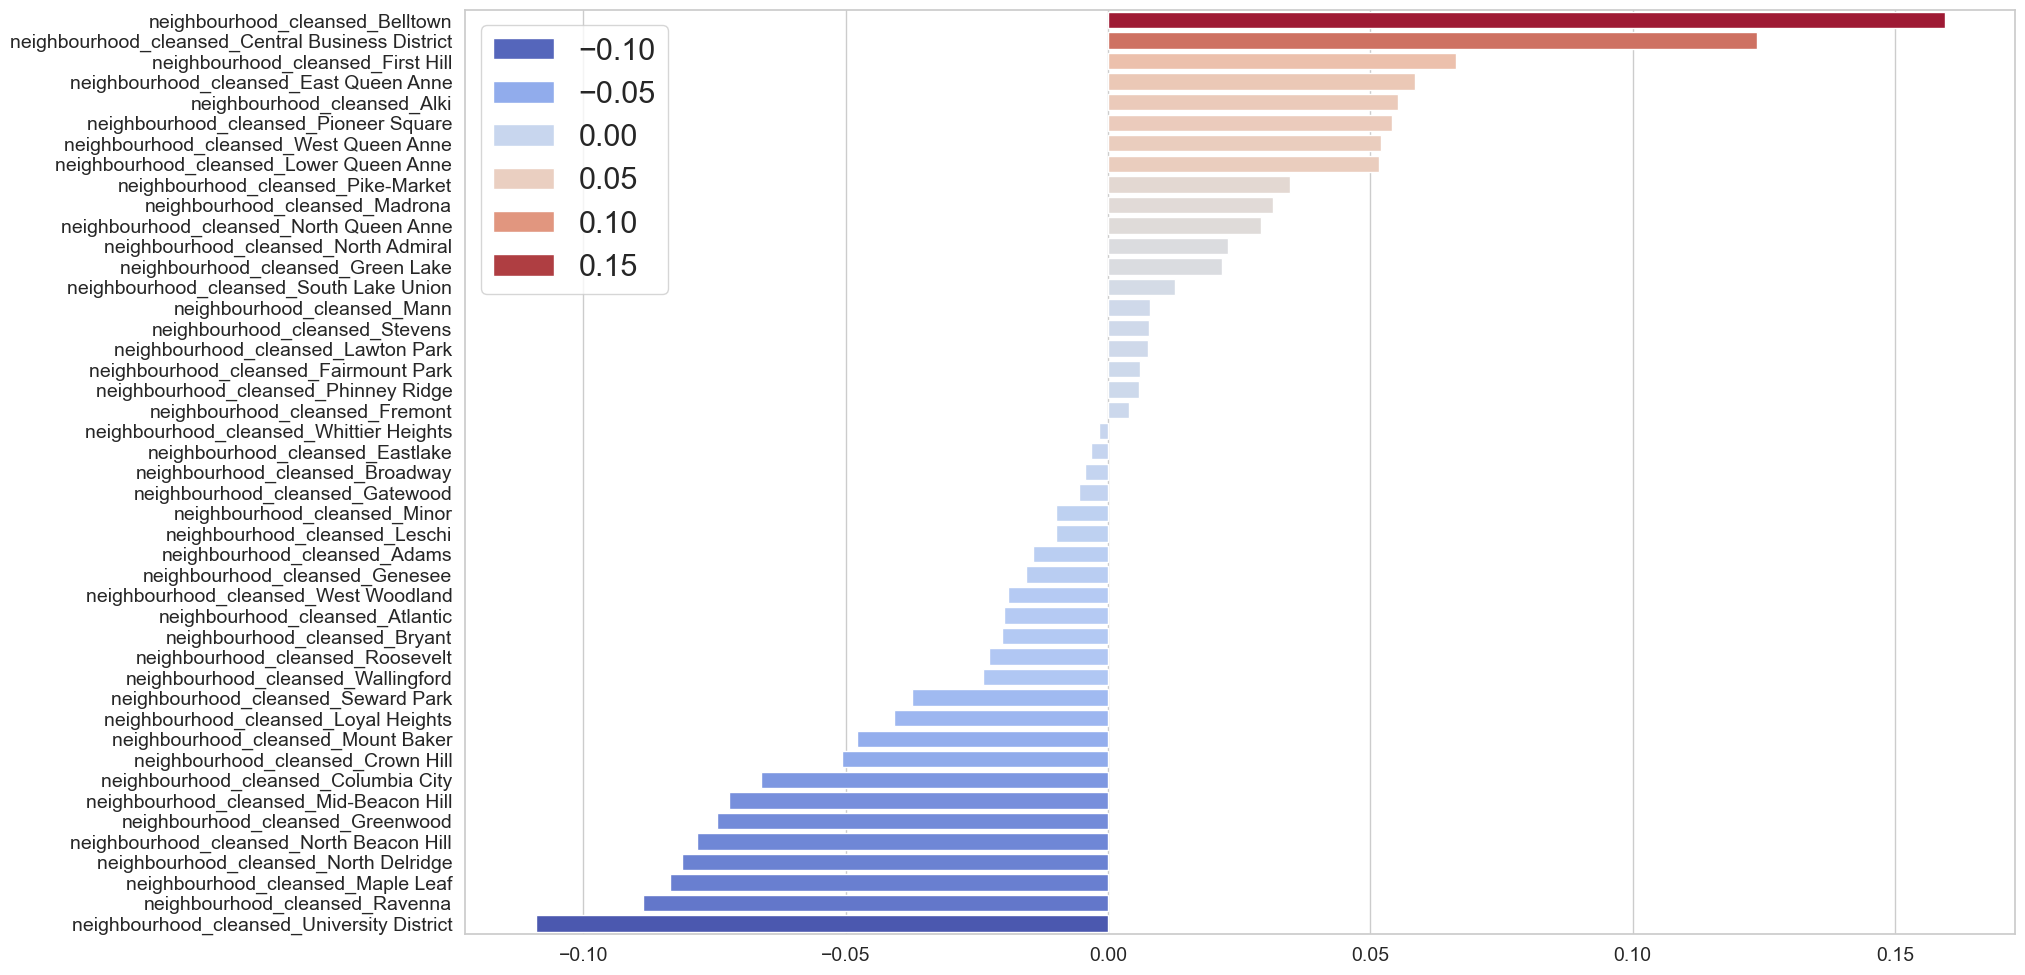

In [136]:
# Correlation location_group_cleansed with price
dummies_location = pd.get_dummies(df_review_ovr_neighbourhood)
corr_location = dummies_location.drop(columns='Median_price').corr(method='spearman')['price'].sort_values(ascending=False).drop('price')

fig=plt.figure(figsize=(20,12), facecolor='w', edgecolor='k')
sns.set_style('whitegrid')
axs = sns.barplot(x=corr_location.values, y=corr_location.index, palette="coolwarm", hue=corr_location.values)
axs.xaxis.set_tick_params(labelsize = 14)
axs.yaxis.set_tick_params(labelsize = 14)
plt.ylabel('');
plt.show()


## 2. How does the season relate to the price (mean over all offers)?

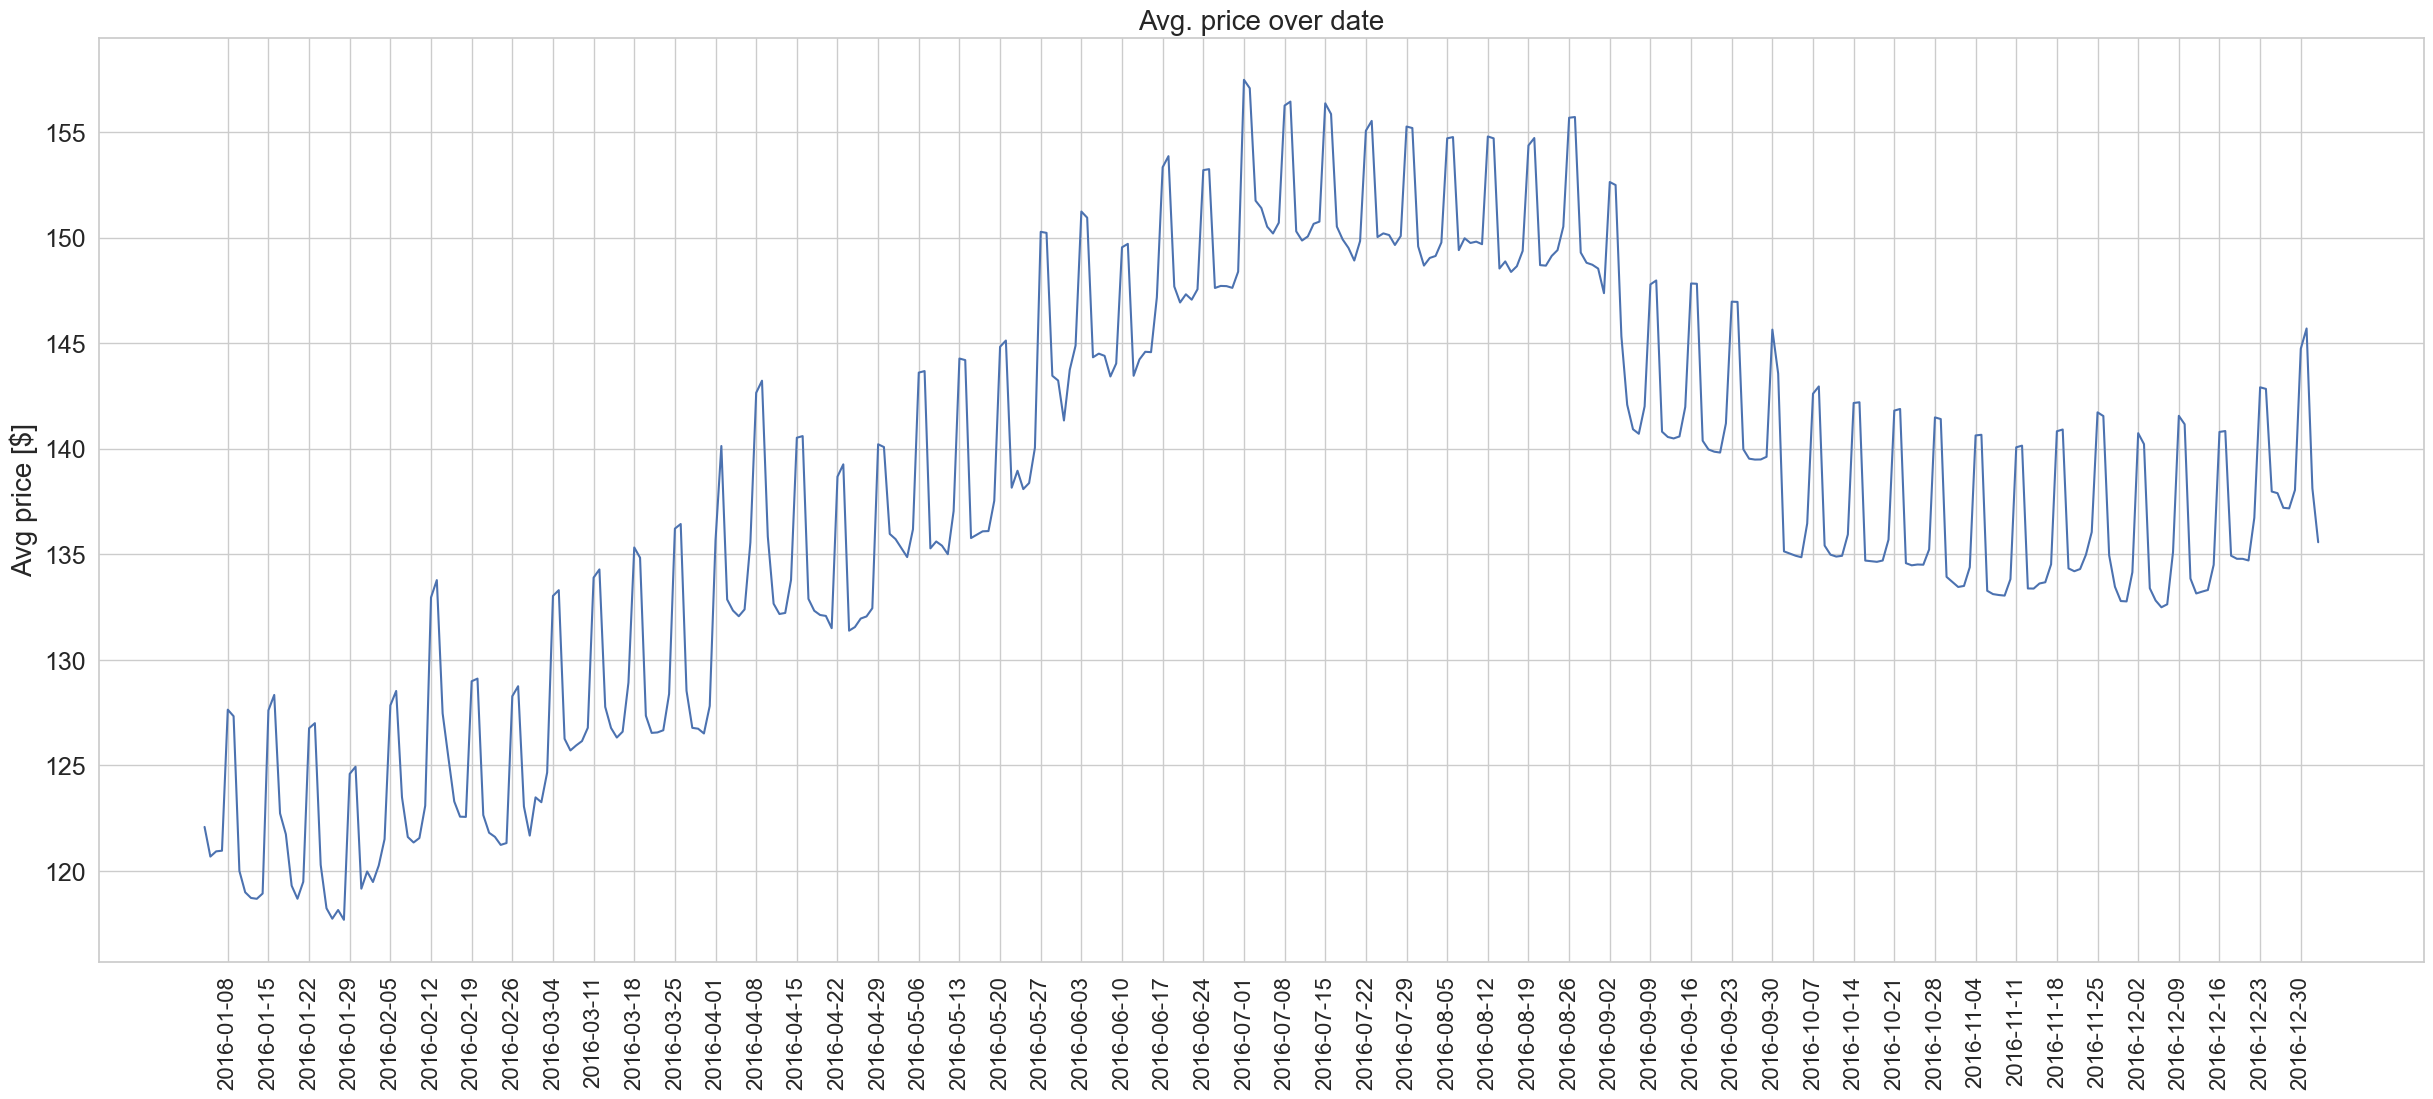

In [137]:
# Select the data
df_price_date = df_calendar[['date', 'price']] 

# Groupby date and take the mean price
price_grouped = df_price_date.groupby('date').mean()
price_grouped.sort_values(by='date')

# Visualize
fig=plt.figure(figsize=(30,12), dpi= 100, facecolor='w', edgecolor='k')
sns.set_style('whitegrid')
axs = sns.lineplot(x=price_grouped.index, y= price_grouped['price'])
axs.set_title('Avg. price over date', fontsize=20)
axs.set_xlabel('')
axs.set_ylabel('Avg price [$]', fontsize=20)
axs.xaxis.set_tick_params(labelsize = 16)
axs.yaxis.set_tick_params(labelsize = 18)
axs.set_xticks(price_grouped.index[4::7], price_grouped.index[4::7], rotation=90);

### Result
- The price follows the seasons and is generally higher during summer and lower during the early winter months.

- There is a cyclic weekly pattern, where the price peaks at the weekend and is rather constant during the other days of the week.

## 3. How do room_type, property_type and amenities relate to the price?

In [138]:
# Create a dataframe of amenities
# Get a list of the unique amenities
amenities = df_listings['amenities'].str.replace('{','').str.replace('}','').str.replace('"','').str.split(',')
set_of_amenities = set([])
for i in range(0, amenities.shape[0]):
    set_of_amenities = set_of_amenities.union(set(amenities.values[i]))
list_amenities = list(set_of_amenities)

# Create the Dataframe of amenities
dummies_amenities = pd.DataFrame( np.zeros((df_listings.shape[0],len(list_amenities))), columns=list_amenities, index=df_listings.index)
for i,ame in enumerate(amenities):
    I = dummies_amenities.columns.get_indexer(ame)
    dummies_amenities.iloc[i,I] = 1

### 3.1 Distribution of the price over the amenities
- There is a small correlation of some amenities with the price
- TVs correlate the highest with the price
- Other positive correlated amenities are family friendly and the presence of an elevator
- Pets on the property correlate negatively with the price

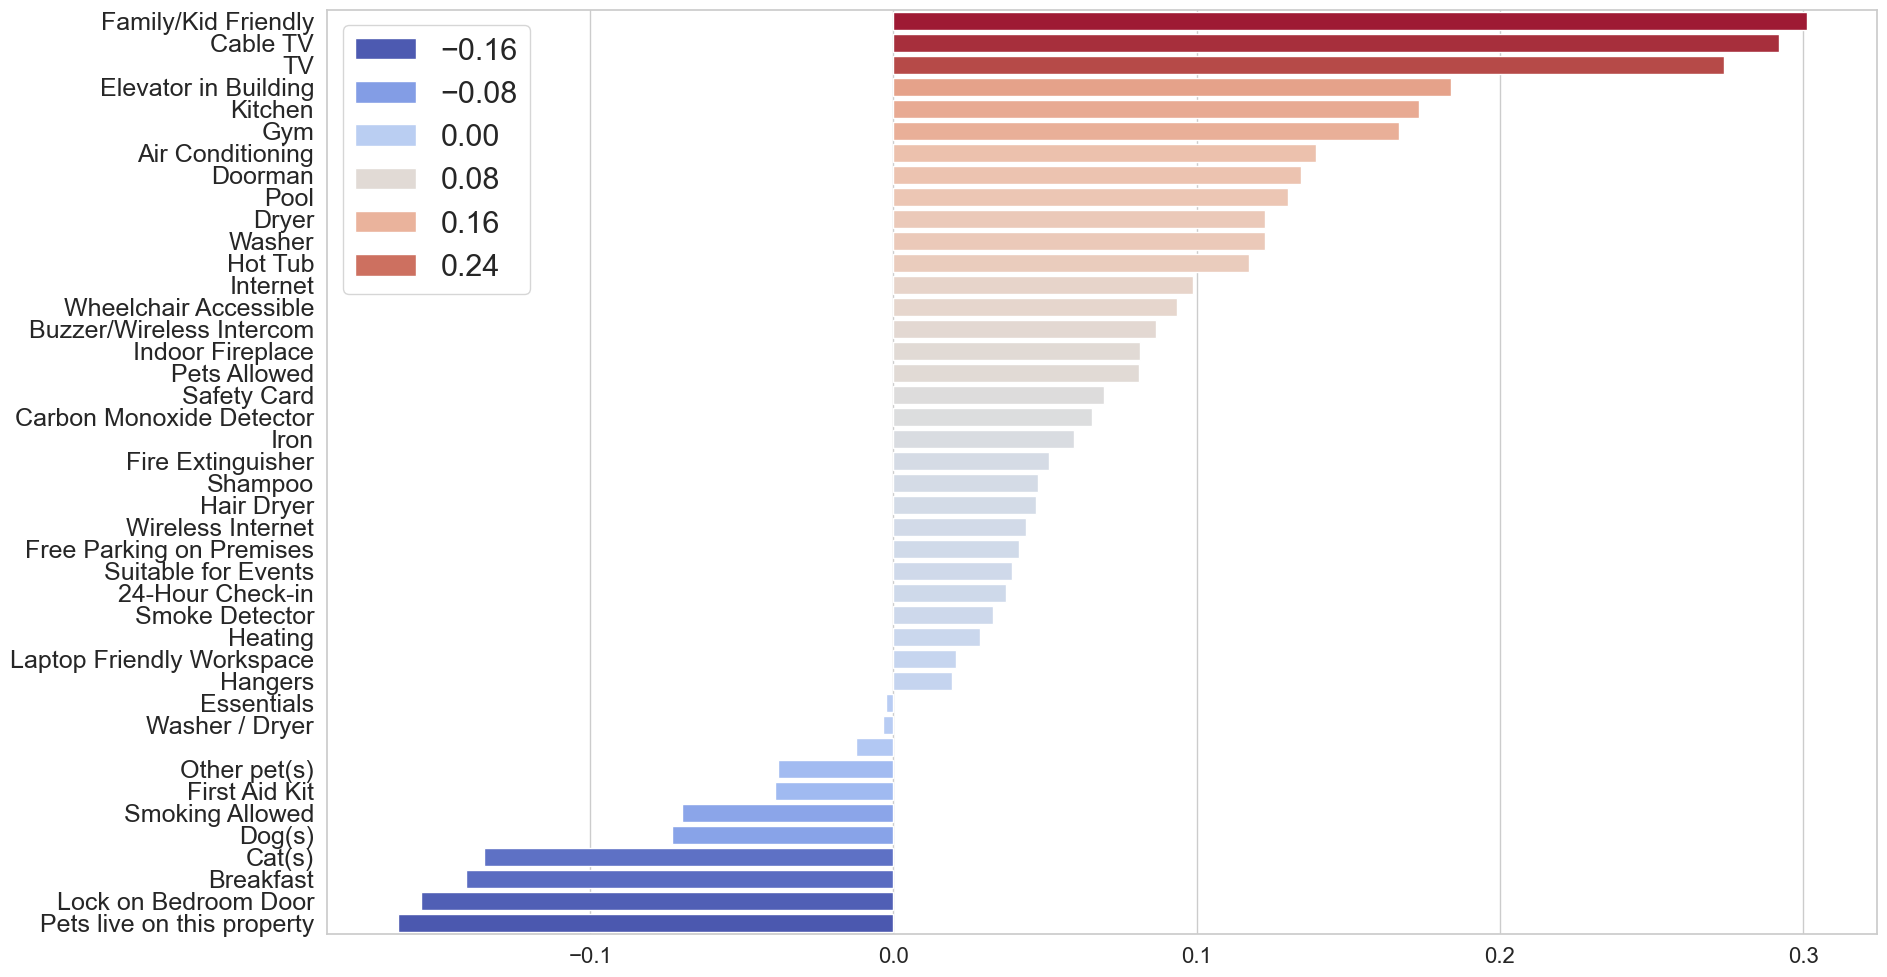

In [139]:
# Correlation with price
df_list_ame_price = pd.concat([df_listings['price'], dummies_amenities], axis=1)
corr_with_price = df_list_ame_price.corr(method='spearman')['price'].sort_values(ascending=False)
corr_with_price.drop('price', axis=0, inplace=True)

# Visualize
fig=plt.figure(figsize=(20,12), facecolor='w', edgecolor='k')
axs = sns.barplot(x=corr_with_price.values, y=corr_with_price.index, palette="coolwarm", hue=corr_with_price.values)
axs.xaxis.set_tick_params(labelsize = 16)
axs.yaxis.set_tick_params(labelsize = 18)
axs.set_ylabel('');

### 3.2 How do the amenities with the most impact on the price correlate with each other?
Choose the amenities with at least +-10.1 correlation coefficient with the price
and see how they correlate.

Most of the amenities have a low correlation, but we see:
- that pets on the property are correlated to Cats
- Gyms are correlated to Elevators

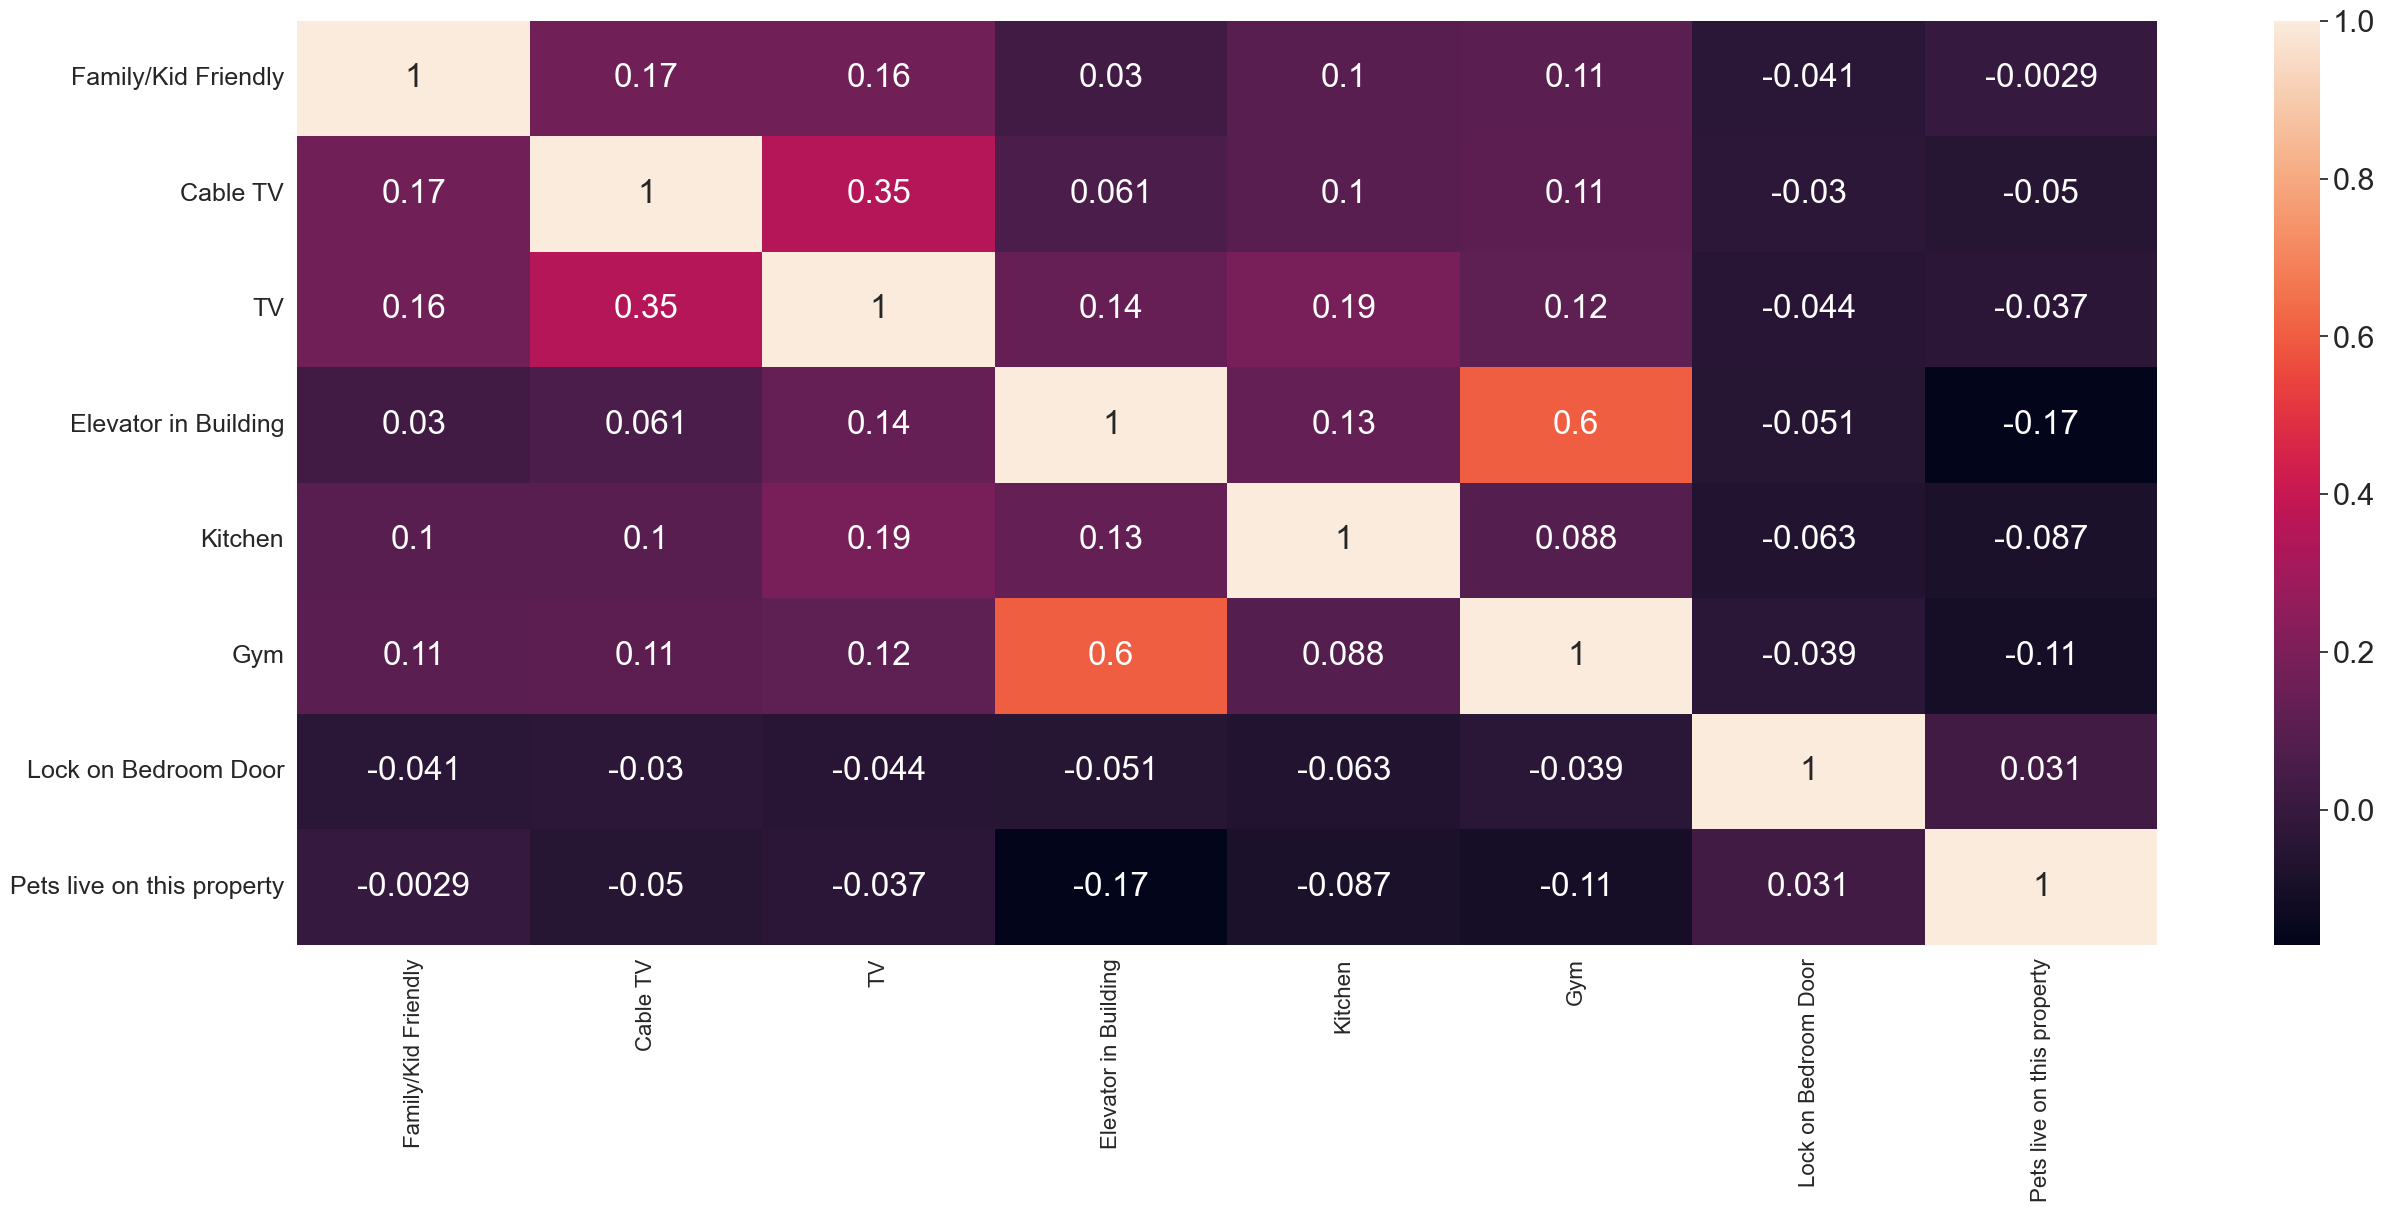

In [140]:
# Correlation amenities
# Select the amenities with at least 0.1 correlation coefficient.
df_important_amenities = df_list_ame_price.drop(columns='price')[ corr_with_price.loc[(np.abs(corr_with_price) > 0.15)].index ]
corr_matrix = df_important_amenities.corr(method='spearman')

# Visualize
fig=plt.figure(figsize=(30,12), facecolor='w', edgecolor='k');
axs = sns.heatmap(corr_matrix, annot=True);
axs.xaxis.set_tick_params(labelsize = 16)
axs.yaxis.set_tick_params(labelsize = 18)

### 3.3. How does the room type relate to the price?
- The three room types have a huge difference in their price distribution
- Private and shared rooms don't cover higher price ranges

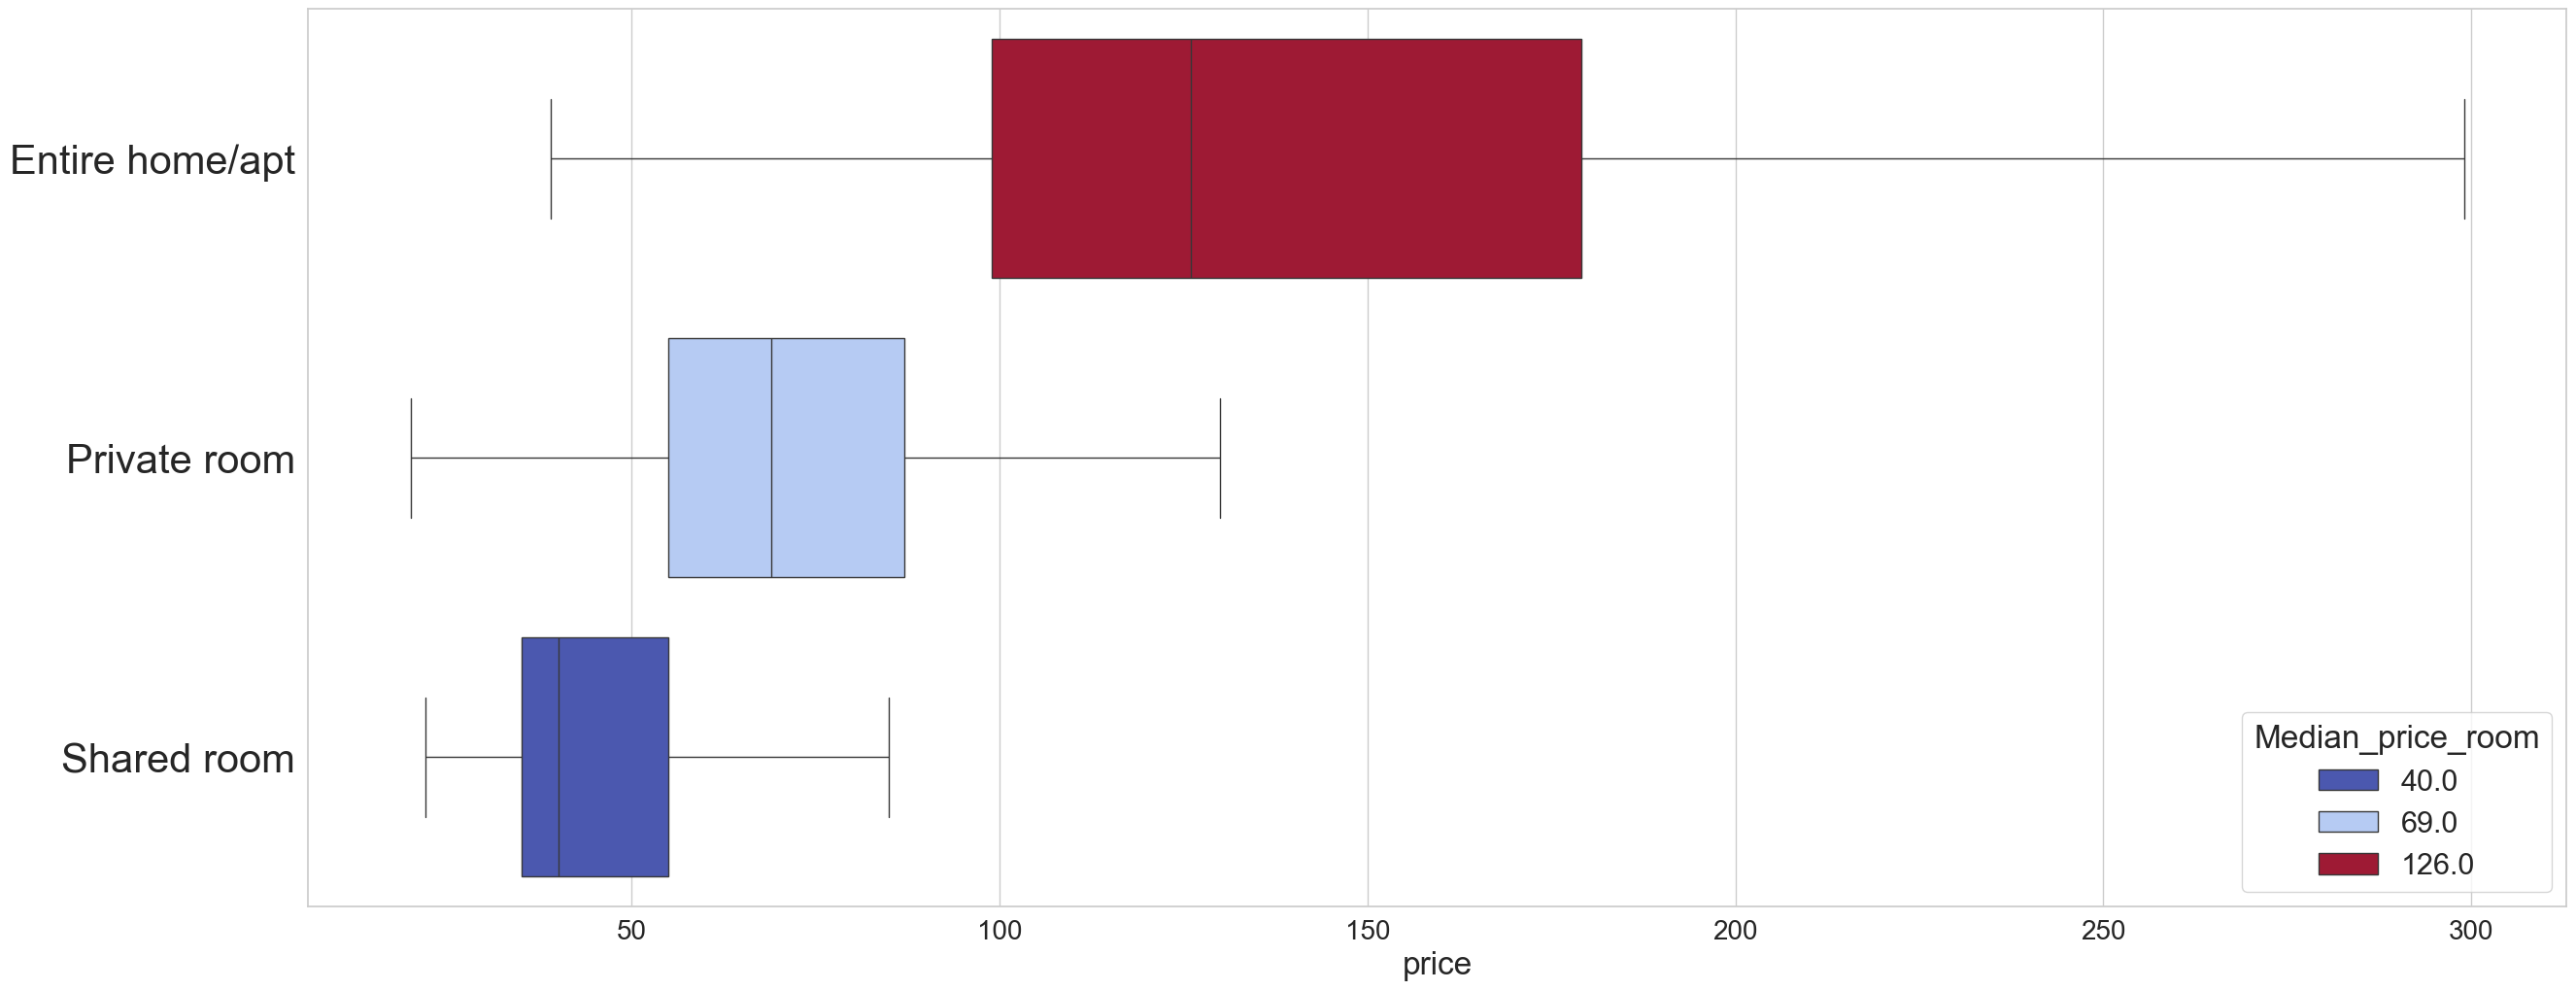

In [141]:
# Impact room type
median_room_type = df_listings.groupby('room_type')['price'].median()
median_data_room = np.array([median_room_type.loc[x] for x in df_listings['room_type']])
df_room = df_listings[['room_type', 'price']]
df_room.insert(0, column='Median_price_room', value=median_data_room)
df_room = df_room.sort_values('Median_price_room', ascending=False)
# Visualize
fig=plt.figure(figsize=(30,12), dpi= 100, facecolor='w', edgecolor='k');
axs = sns.boxplot(data=df_room, x='price', y='room_type', showfliers=False, palette="coolwarm", hue='Median_price_room');
axs.xaxis.set_tick_params(labelsize = 20)
axs.yaxis.set_tick_params(labelsize = 30)
axs.set_ylabel('');

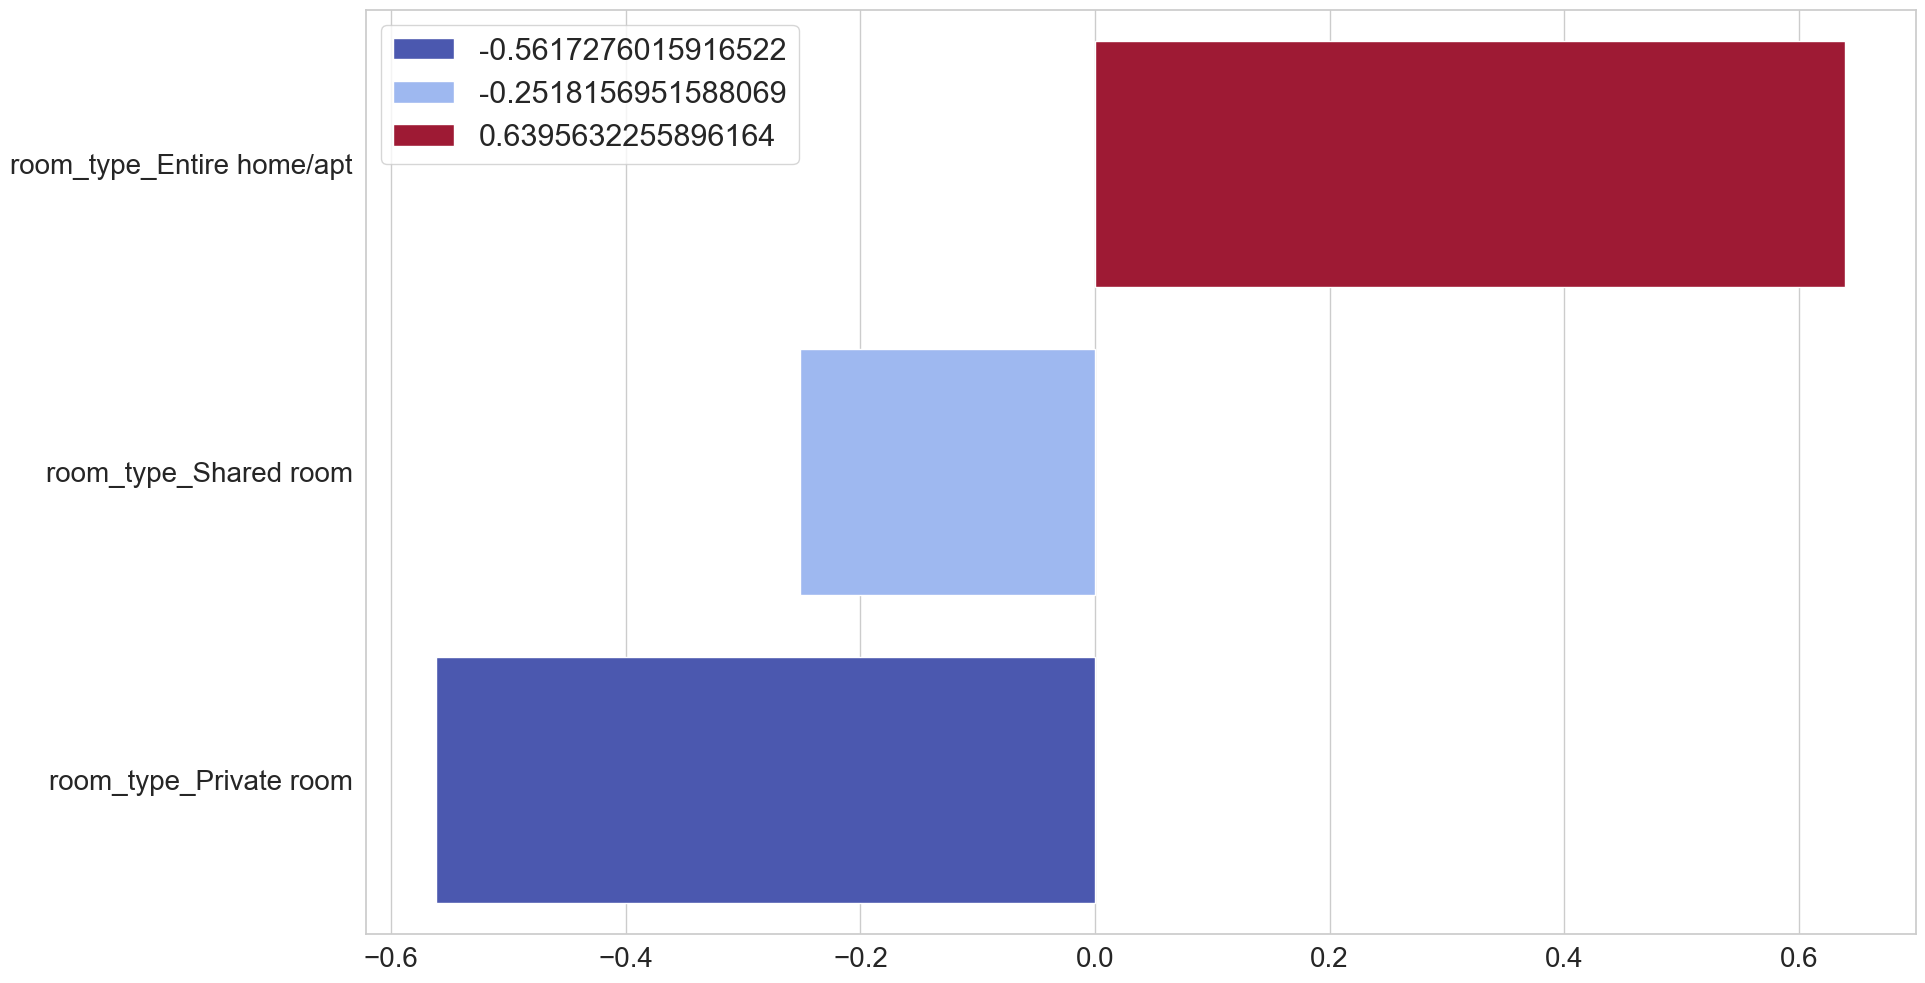

In [142]:
# Correlation room_type and price
# Correlation with price
corr_room_with_price = pd.get_dummies(df_listings[['price', 'room_type']]).corr('spearman')['price'].sort_values(ascending=False).drop('price', axis=0)

# Visualize
fig=plt.figure(figsize=(20,12), facecolor='w', edgecolor='k')
axs = sns.barplot(x=corr_room_with_price.values, y=corr_room_with_price.index, palette="coolwarm", hue=corr_room_with_price.values)
axs.xaxis.set_tick_params(labelsize = 20)
axs.yaxis.set_tick_params(labelsize = 20)
axs.set_ylabel('');

### 3.4. How does the property type relate to the price?
- The different property types distinguish a lot in their distribution
- Especially tents, cabins, and dorms have a small price range
- Boats have a huge pricerange
- There is very low correlation of the property type with the price, though

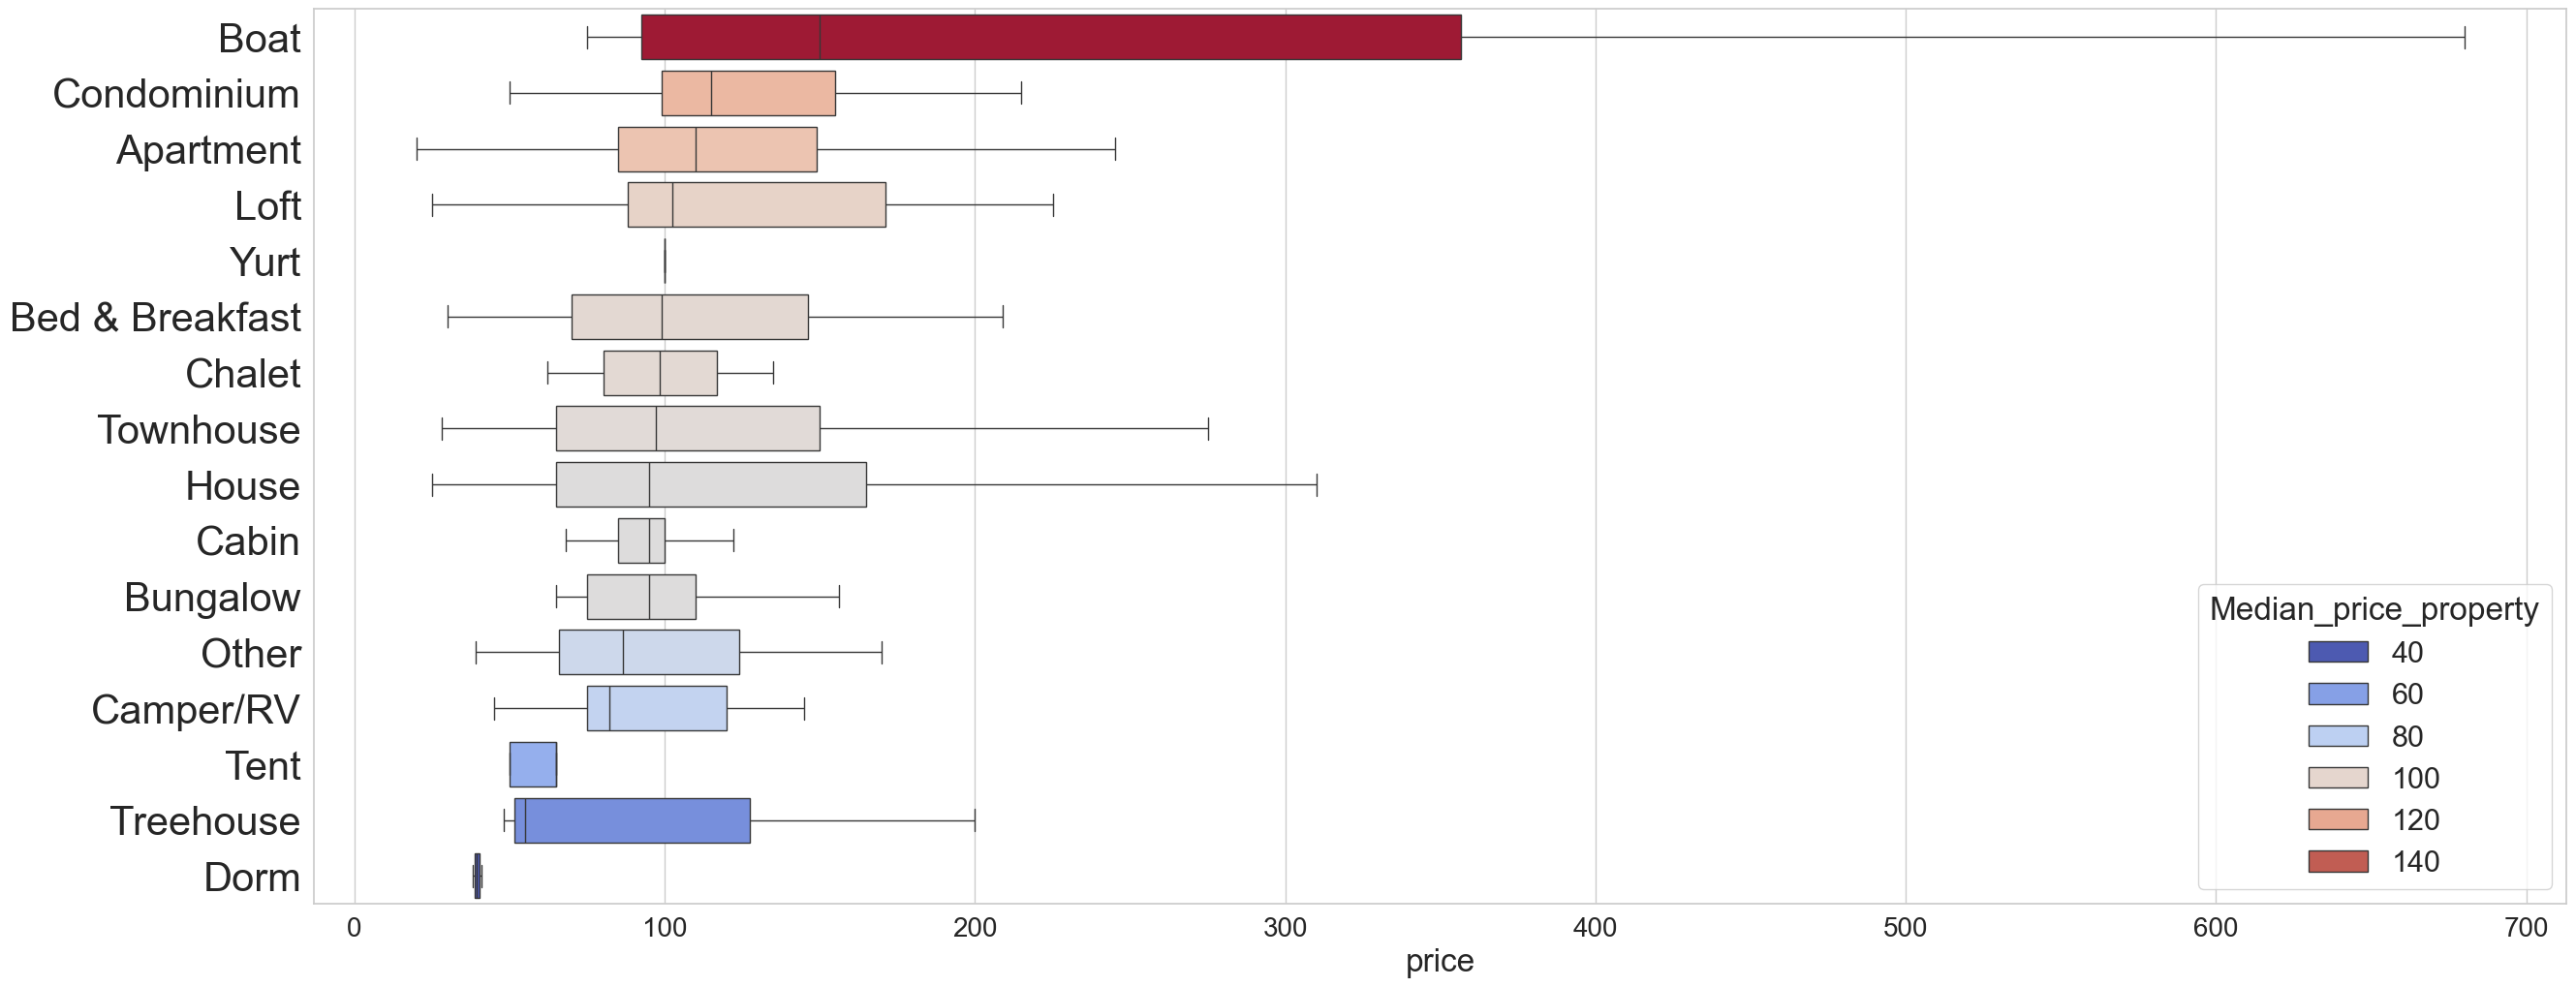

In [143]:
# Impact property type
median_property_type = df_listings.groupby('property_type')['price'].median()
median_data_property = np.array([median_property_type.loc[x] for x in df_listings['property_type']])
df_property = df_listings[['property_type', 'price']]
df_property.insert(0, column='Median_price_property', value=median_data_property)
df_property = df_property.sort_values('Median_price_property', ascending=False)

# Visualize
fig=plt.figure(figsize=(30,12), dpi= 100, facecolor='w', edgecolor='k');
axs = sns.boxplot(data=df_property, x='price', y='property_type', showfliers=False, palette="coolwarm", hue='Median_price_property');
axs.xaxis.set_tick_params(labelsize = 20)
axs.yaxis.set_tick_params(labelsize = 30)
axs.set_ylabel('');

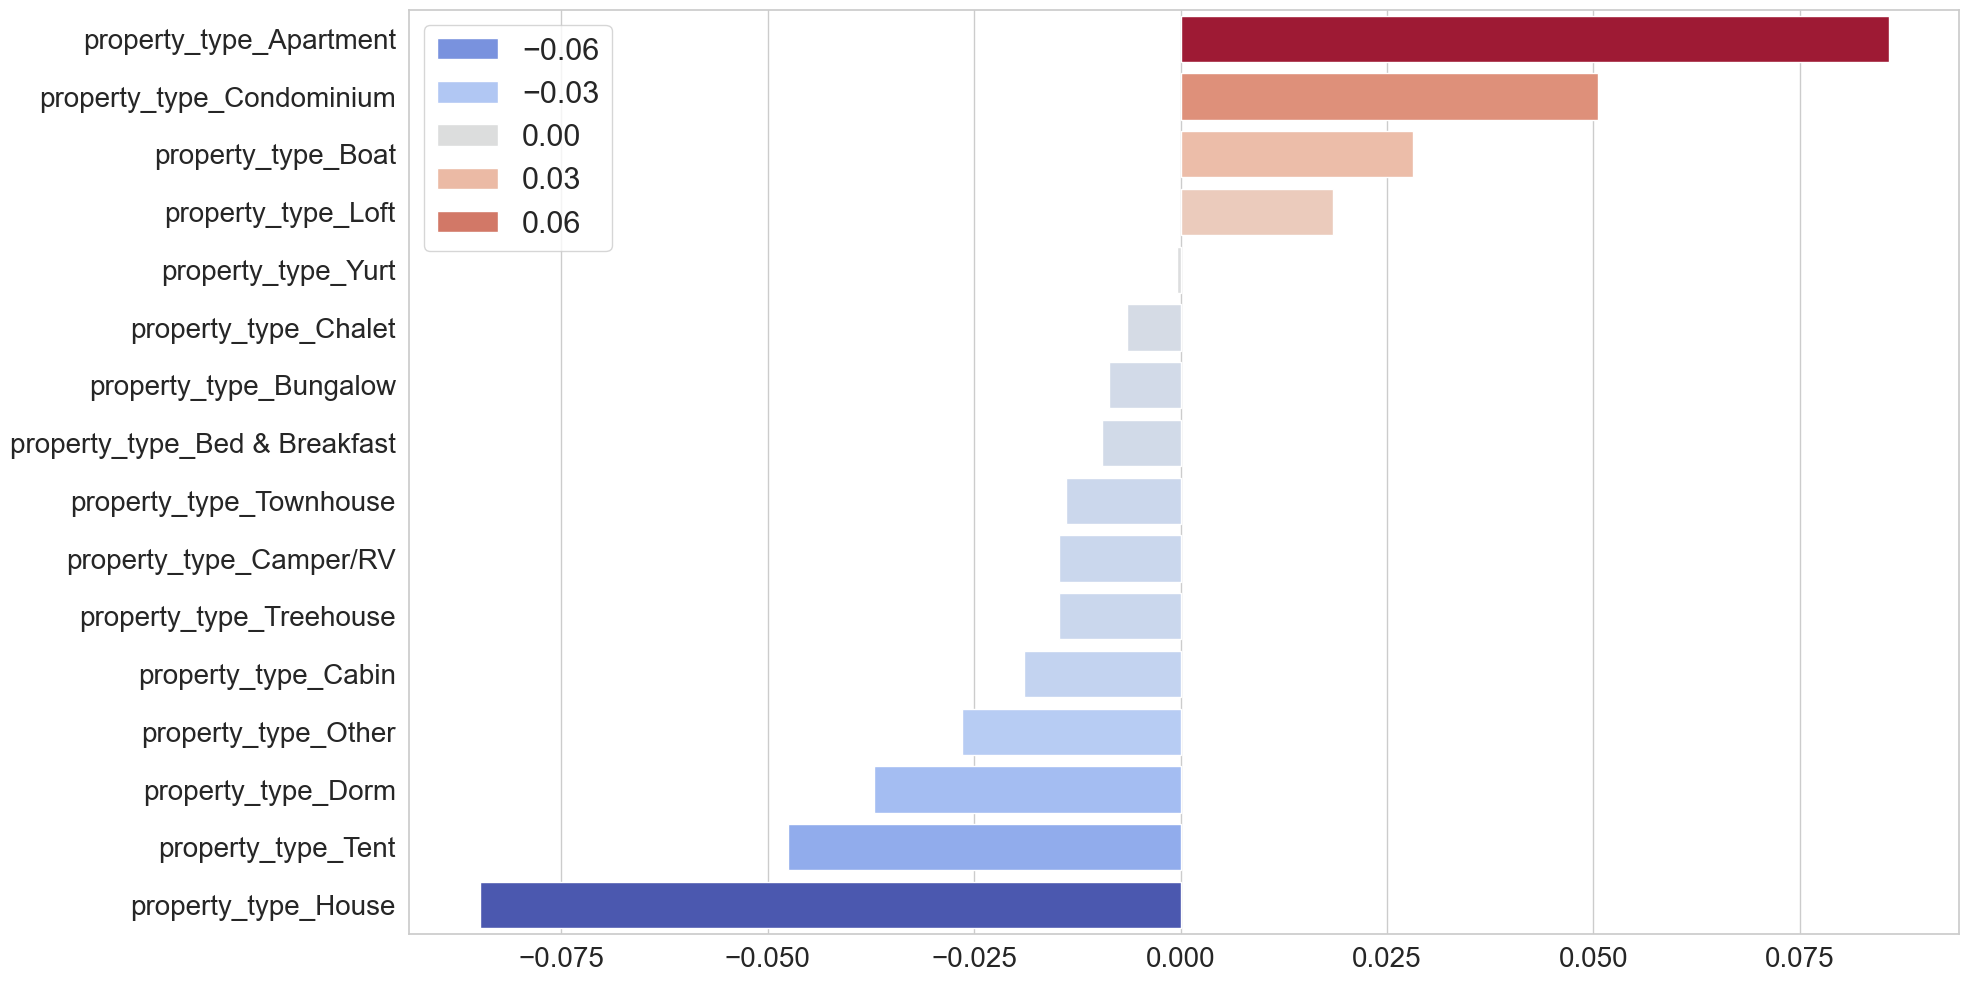

In [144]:
# Correlation property_type and price
# Correlation with price
corr_property_with_price = pd.get_dummies(df_listings[['price', 'property_type']]).corr('spearman')['price'].sort_values(ascending=False).drop('price', axis=0)

# Visualize
fig=plt.figure(figsize=(20,12), facecolor='w', edgecolor='k')
axs = sns.barplot(x=corr_property_with_price.values, y=corr_property_with_price.index, palette="coolwarm", hue=corr_property_with_price.values)
axs.xaxis.set_tick_params(labelsize = 20)
axs.yaxis.set_tick_params(labelsize = 20)
axs.set_ylabel('');

### Results
- The amenities are not highly corelated with the price (<0.2)
- The three room types have a very different distribution of the price
- The property types have a very different distribution of the price
- The property types do not correlate well with the price
- Private and Shared rooms do not cover higher prices well

## 4. Can the price be predicted with a regression model?
Let's try to predict the price with a XGBoost regressor

'RMSE: 61.11731860988448'

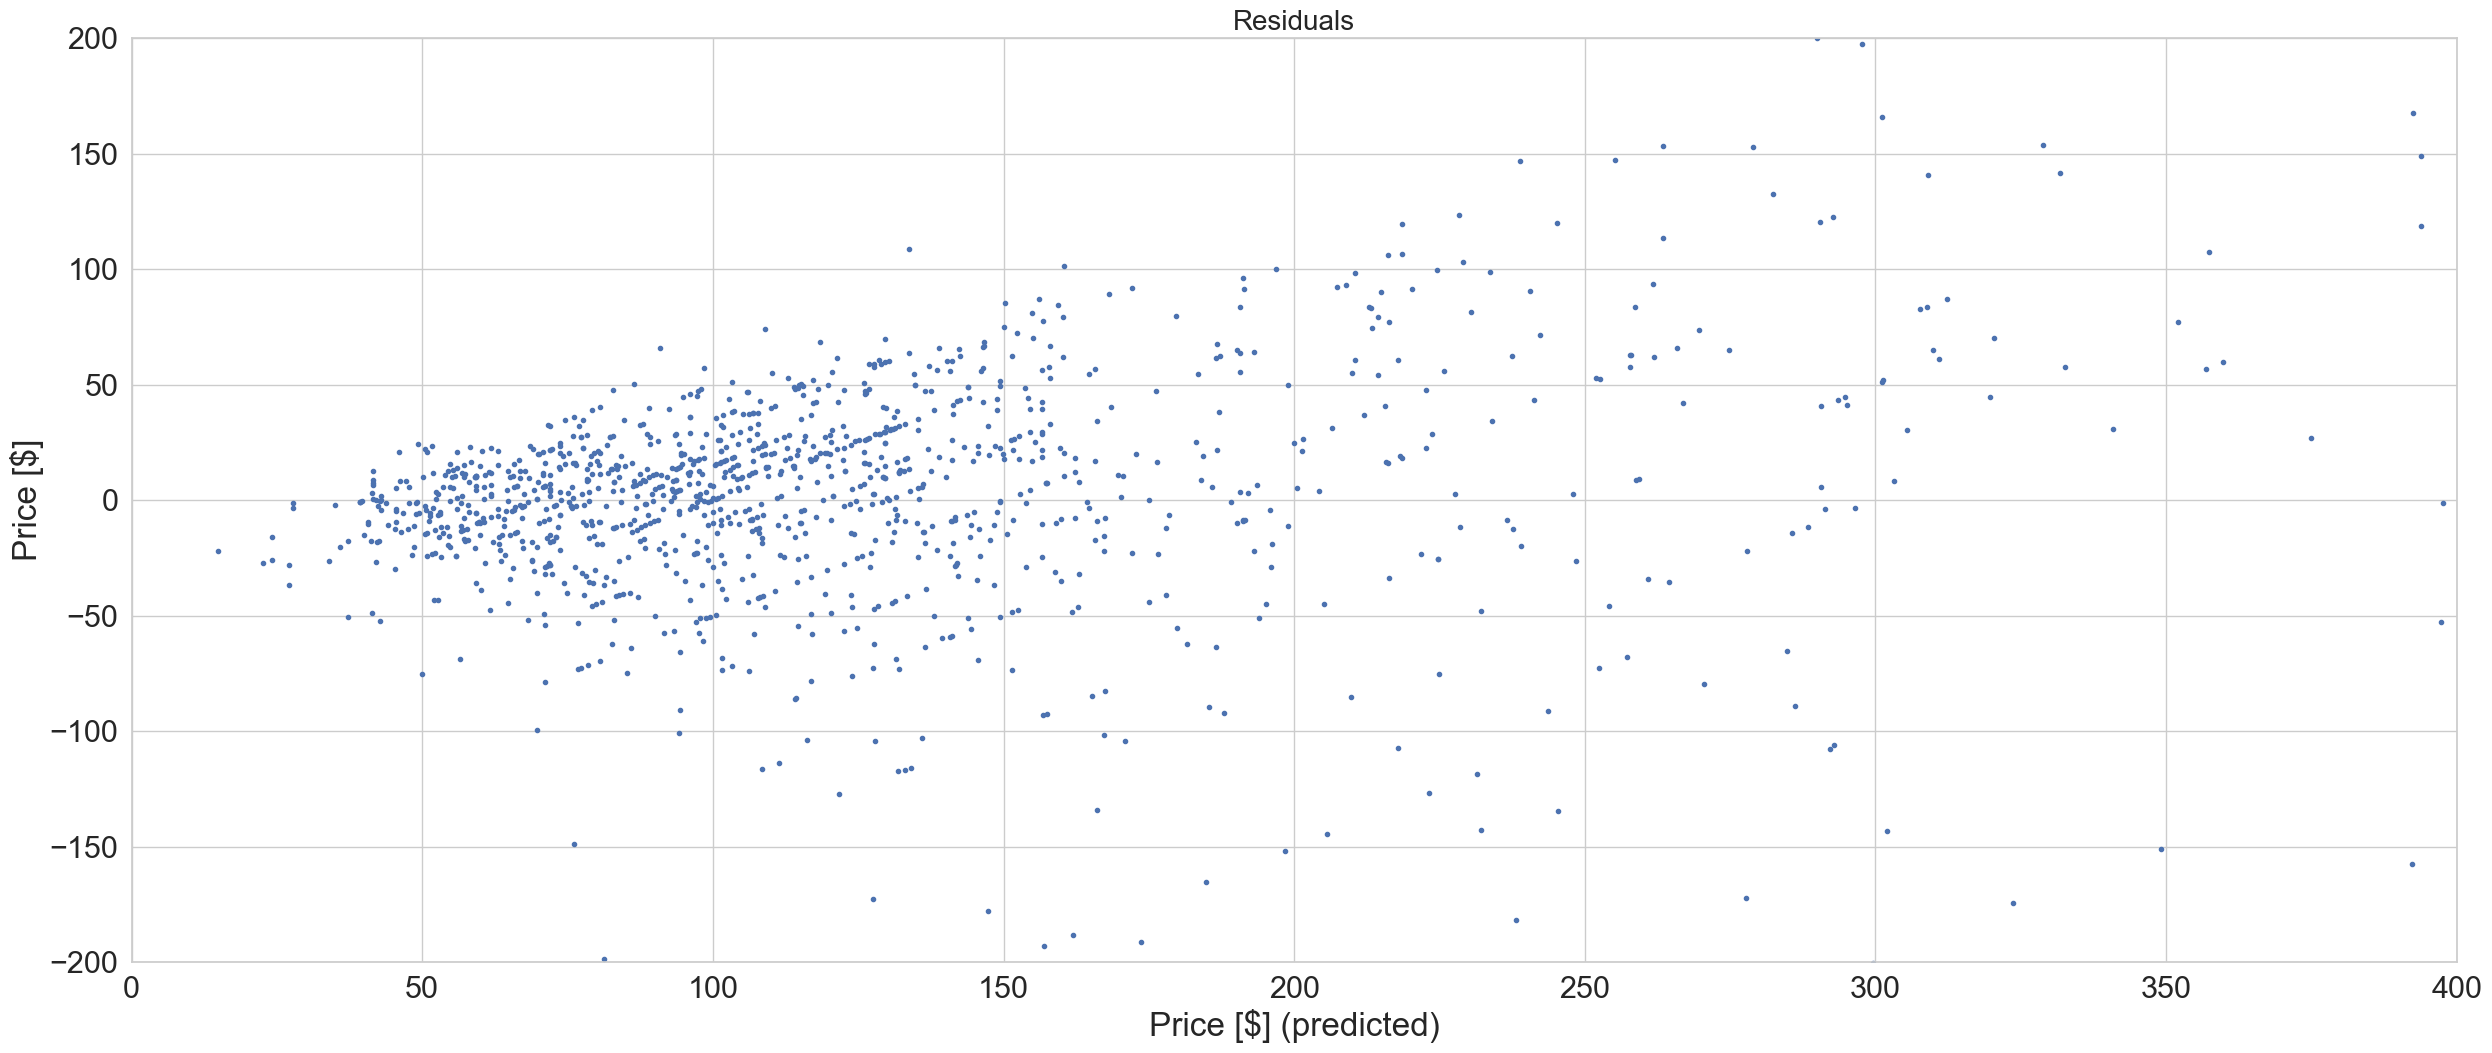

In [145]:
# Price prediction
# Feature datatype columns
col_categoric = ['neighbourhood_group_cleansed',  'property_type', 'room_type', 'bed_type', 'instant_bookable', 'cancellation_policy']
col_numeric = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'cleaning_fee', 'guests_included']
col_amenities = df_important_amenities.columns

# Create feature dataframe
X = pd.concat([ df_listings[col_numeric], df_listings[col_categoric], df_list_ame_price.drop(columns='price')], axis=1)
y = df_listings['price']

# Generate preprocessor
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categoric_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
preprocessor = ColumnTransformer(transformers=[('numeric', numeric_transformer, col_numeric), 
                                                    ('categoric', categoric_transformer, col_categoric )])
# Select model
model = XGBRegressor(n_estimators=100, max_depth=50, reg_lambda=0, learning_rate=0.2, 
                     min_child_weight=30)
# Build regressor pipeline
pipeline_regressor = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('regressor', model)])
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=4)
# Train model
pipeline_regressor.fit(X_train, y_train) #, regressor__sample_weight=sample_weight)


# Evaluation
###########################
from sklearn.metrics import root_mean_squared_error
y_test_pred = pipeline_regressor.predict(X_test)
I_sort = np.argsort(y_test_pred)
display( 'RMSE: '+str( root_mean_squared_error(y_test_pred[I_sort], np.array(y_test)[I_sort]) )  ) 
t = np.arange(0,y_test.shape[0])
I_sort = np.argsort(np.array(y_test))
fig=plt.figure(figsize=(30,12), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(np.array(y_test_pred)[I_sort], ( y_test_pred[I_sort]- np.array(y_test)[I_sort]), '.')
plt.title('Residuals', fontsize='20')
plt.xlabel('Price [$] (predicted)', fontsize='24')
plt.ylabel('Price [$]', fontsize='24')
plt.xlim([0, 400])
plt.ylim([-200, 200])
plt.show()
###########################

### Result
The model works good on predictions between 40-150€, where it has approximatly half of the predicted value as confidence intervall.

Out of that range, it might be of no good use as a price indicator.

The price is a target variable with unbalanced samplesize. It might help to improve the model by binning/clustering the price and predicting the price bins/clusters.

## Summary
The results from this short EDA showed:

1. The price profile of different locations

2. The price has seasonal trends (higher in summer) and is higher on the weekend than on the workdays

3. Room type, Property type have very distinct price distributions

4. Some amendities (especially TV) have an impact on the price

5. The price can be predicted in a range between 40-150$, with a confidence intervall around roughly 50%.
    This might be something, our fictious room provider could use to choose his price.